In [34]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose
# for determining ARIMA orders
from pmdarima import auto_arima                              

from datetime import datetime
from functools import partial

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [35]:
train = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/train.csv")
oil = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/oil.csv")
holidays = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/holidays_events.csv")
stores = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/stores.csv")

In [36]:
# Merging the data
df = train.merge(oil, on = 'date', how='left')
df = df.merge(holidays, on = 'date', how='left')
df = df.merge(stores, on = 'store_nbr', how='left')
df = df.rename(columns = {"type_x" : "holiday_type", 
                                  "type_y" : "store_type"})

In [37]:
df.shape

(3054348, 16)

In [38]:
# Filtering Data based on family to consider 'Grocery I'
df1 = df[df['family'] == 'GROCERY I']

In [40]:
# Converting to date
to_datetime_fmt = partial(pd.to_datetime)

#performing a group by on date and taking the sum of sales
df2 = df1.groupby('date')['sales'].sum()
df2=df2.reset_index()

In [41]:
# Viewing the data
df2

,date,sales
0,2013-01-01,700.000
1,2013-01-02,202020.000
2,2013-01-03,144878.000
3,2013-01-04,135754.000
4,2013-01-05,188356.000
...,...,...
1679,2017-08-11,238221.922
1680,2017-08-12,238627.633
1681,2017-08-13,258442.452
1682,2017-08-14,225355.694


In [42]:
# Setting the date as the index
df.set_index('date',inplace=True)

In [43]:
#converting object format to date format
df2['date'] = df2['date'].apply(to_datetime_fmt)

df2.set_index('date',inplace=True)
df2.head()

,sales
date,
2013-01-01,700.0
2013-01-02,202020.0
2013-01-03,144878.0
2013-01-04,135754.0
2013-01-05,188356.0


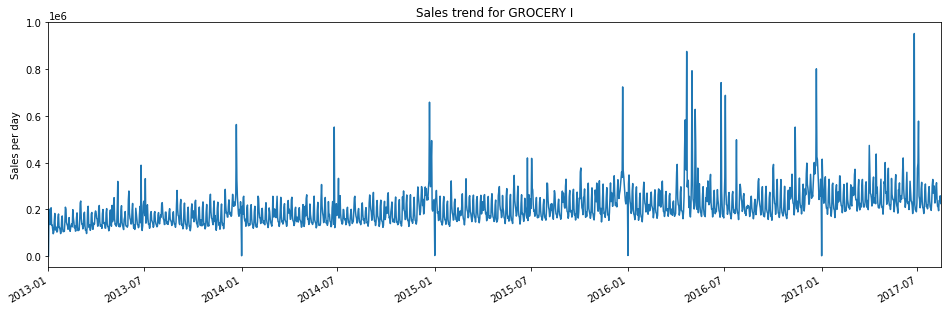

In [44]:
# Visualising the sales trend for Grocery I for each day
title='Sales trend for GROCERY I'
ylabel='Sales per day'
xlabel='' 

ax = df2['sales'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [45]:
def mape(Y_actual, y_forecasted):
    val = np.mean(np.abs((Y_actual - y_forecasted)/Y_actual))*100
    return val

In [46]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [47]:
adf_test(df2['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -4.229222
p-value                    0.000588
# lags used               22.000000
# observations          1661.000000
critical value (1%)       -3.434293
critical value (5%)       -2.863282
critical value (10%)      -2.567697
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [48]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df2['sales'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1684
Model:             SARIMAX(5, 1, 3)x(1, 0, [], 12)   Log Likelihood              -20825.930
Date:                             Fri, 13 May 2022   AIC                          41671.860
Time:                                     16:40:43   BIC                          41726.143
Sample:                                          0   HQIC                         41691.966
                                            - 1684                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5125      0.017     88.346      0.000       1.479       1.546
ar.L2         -1.2963      0.036    -36.029      0.000      -1.367      -1.226
ar.L3          0.4050      0.050      8.121      0.000       0.307       0.503
ar.L4         -0.1882      0.046     -4.095      0.000      -0.278      -0.098
ar.L5          0.1806      0.021      8.733      0.000       0.140       0.221
ma.L1         -2.1866      0.013   -169.812      0.000      -2.212      -2.161
ma.L2          2.1181      0.023     93.499      0.000       2.074       2.163
ma.L3         -0.9237      0.012    -76.333      0.000      -0.947      -0.900
ar.S.L12      -0.0570      0.029     -1.966      0.049      -0.114      -0.000
sigma2      3.417e+09   1.06e-11   3.22e+20      0.000    3.42e+09    3.42e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):             99234.30
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                             4.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.97e+35. Standard errors may be unstable.
"""

In [49]:
df2 = df2.reset_index()
df2

,date,sales
0,2013-01-01,700.000
1,2013-01-02,202020.000
2,2013-01-03,144878.000
3,2013-01-04,135754.000
4,2013-01-05,188356.000
...,...,...
1679,2017-08-11,238221.922
1680,2017-08-12,238627.633
1681,2017-08-13,258442.452
1682,2017-08-14,225355.694


In [50]:
# Set four weeks for testing
train = df2.iloc[:1457]
test = df2.iloc[1457:]

### SARIMA

In [52]:
model = SARIMAX(train['sales'],order=(1,0,1),seasonal_order=(0, 0, [1, 2], 12),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   sales   No. Observations:                 1457
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood              -18173.963
Date:                                 Fri, 13 May 2022   AIC                          36357.926
Time:                                         16:41:22   BIC                          36384.347
Sample:                                              0   HQIC                         36367.783
                                                - 1457                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2104.258      0.000       0.999       1.001
ma.L1         -0.8779      0.009    -92.844      0.000      -0.896      -0.859
ma.S.L12      -0.1696      0.029     -5.767      0.000      -0.227      -0.112
ma.S.L24      -0.1652      0.027     -6.069      0.000      -0.218      -0.112
sigma2      4.692e+09   1.48e-12   3.16e+21      0.000    4.69e+09    4.69e+09
===================================================================================
Ljung-Box (L1) (Q):                 106.99   Jarque-Bera (JB):             25438.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             2.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.45e+36. Standard errors may be unstable.
"""

In [53]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
test['predictions'] = results.predict(start=start, end=end, dynamic=False).rename('SARIMA Predictions')

In [55]:
test = test.set_index('date')

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

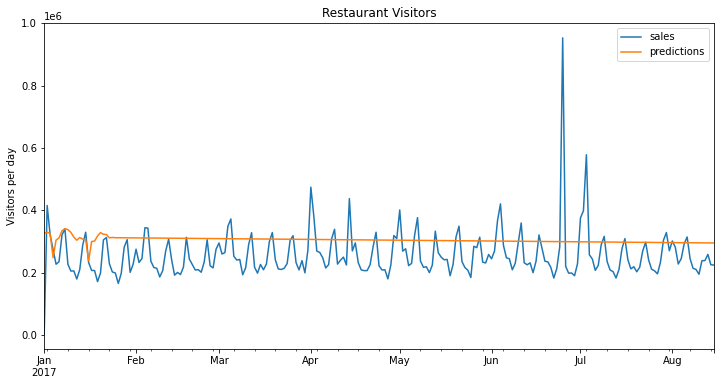

In [56]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
test['predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [57]:
error1 = mape(test['sales'], test['predictions'])

print(' MAPE for SARIMAX: ', error1)

 MAPE for SARIMAX:  100.44788189628618


In [58]:
#performing a group by on date and taking the sum of sales
df2 = df1.groupby('date')['sales'].sum()
df2=df2.reset_index()

In [59]:
df2.shape

(1684, 2)

In [60]:
#performing a group by on date and taking the sum of sales
df3 = df1.groupby('date')['onpromotion'].mean()
df3=df3.reset_index()
df3.shape

(1684, 2)

In [61]:
df2 = df2.merge(df3, on = 'date', how='left')
df2.shape

(1684, 3)

In [62]:
# Set four weeks for testing
train = df2.iloc[:1457]
test = df2.iloc[1457:]

### SARIMAX with "onpromotion" as exogenous variable

In [64]:
model = SARIMAX(train['sales'],exog=train['onpromotion'],order=(1,1,1),seasonal_order=(0, 0, [1, 2], 12),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   sales   No. Observations:                 1457
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood              -18093.814
Date:                                 Fri, 13 May 2022   AIC                          36199.627
Time:                                         16:42:14   BIC                          36231.328
Sample:                                              0   HQIC                         36211.455
                                                - 1457                                         
Covariance Type:                                   opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion  2684.1902    175.239     15.317      0.000    2340.727    3027.653
ar.L1           0.3667      0.020     17.955      0.000       0.327       0.407
ma.L1          -0.9424      0.009   -101.585      0.000      -0.961      -0.924
ma.S.L12       -0.1633      0.031     -5.234      0.000      -0.224      -0.102
ma.S.L24       -0.0804      0.036     -2.254      0.024      -0.150      -0.010
sigma2       4.377e+09   2.88e-05   1.52e+14      0.000    4.38e+09    4.38e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):             30559.27
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             2.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+29. Standard errors may be unstable.
"""

In [65]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['onpromotion']]  # requires two brackets to yield a shape of (35,1)
test['predictions'] = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

In [66]:
test = test.set_index('date')

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

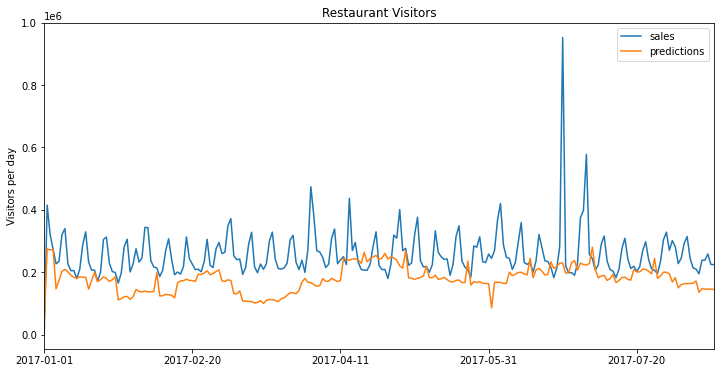

In [67]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
test['predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [68]:
# Evaluating the model
error3 = mape(test['sales'], test['predictions'])

print(' MAPE for SARIMAX: ', error3)

 MAPE for SARIMAX:  37.93110236906045
